In [ ]:
%pip install librosa numpy pandas seaborn matplotlib

In [2]:
import librosa
import numpy as np
import pandas as pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
spin_data = pd.read_csv("./Dataset/Self_reported_score.csv")
def label_anxiety(spin_score):
    if spin_score <= 20:
        return "Low Anxiety"
    elif 21 <= spin_score <= 40:
        return "Moderate Anxiety"
    else:
        return "High Anxiety"
spin_data['Anxiety_Level'] = spin_data['SPIN'].apply(label_anxiety)
print(spin_data.head())
spin_data.to_csv('labeled_spin_data.csv', index=False)


   Participant_Id  SPIN     Anxiety_Level
0               1    17       Low Anxiety
1               2    44      High Anxiety
2               5    26  Moderate Anxiety
3               6    24  Moderate Anxiety
4               8    34  Moderate Anxiety


In [4]:
def extract_social_anxiety_features(wav_file):
    # Load the audio file
    audio_data, sample_rate = librosa.load(wav_file, sr=None)
    pitch, _ = librosa.piptrack(y=audio_data, sr=sample_rate)
    pitch_values = pitch[pitch > 0]
    
    if len(pitch_values) > 1:
        mean_pitch = np.mean(pitch_values)
        pitch_variability = np.std(pitch_values)
    else:
        mean_pitch = np.nan
        pitch_variability = np.nan
    tempo, _ = librosa.beat.beat_track(y=audio_data, sr=sample_rate)
    rms = librosa.feature.rms(y=audio_data)
    mean_intensity = np.mean(rms)
    intensity_variability = np.std(rms)
    non_silent_intervals = librosa.effects.split(audio_data, top_db=30)
    if len(non_silent_intervals) > 0:
        total_silence_duration = (len(audio_data) - np.sum([end - start for start, end in non_silent_intervals])) / sample_rate
        num_pauses = len(non_silent_intervals)
    else:
        total_silence_duration = np.nan
        num_pauses = 0
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
    mean_mfcc = np.mean(mfccs, axis=1)
    std_mfcc = np.std(mfccs, axis=1)
    spectral_entropy = np.mean(librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate))
    try:
        lpc_coeffs = librosa.lpc(audio_data, order=2)
        formant_frequencies = np.roots(lpc_coeffs)
        real_formants = np.real(formant_frequencies[formant_frequencies > 0])[:2]  # Take the first two formants
        formant_1 = real_formants[0] if len(real_formants) > 0 else np.nan
        formant_2 = real_formants[1] if len(real_formants) > 1 else np.nan
    except Exception:
        formant_1 = np.nan
        formant_2 = np.nan
    jitter = np.mean(np.abs(np.diff(pitch_values))) if len(pitch_values) > 1 else np.nan
    shimmer = np.mean(np.abs(np.diff(rms))) if len(rms) > 1 else np.nan
    hnr = librosa.effects.harmonic(audio_data).mean()
    speech_segment_durations = np.sum([end - start for start, end in non_silent_intervals]) / sample_rate if len(non_silent_intervals) > 0 else np.nan

    return {
        'mean_pitch': mean_pitch,
        'pitch_variability': pitch_variability,
        'tempo': tempo,
        'mean_intensity': mean_intensity,
        'intensity_variability': intensity_variability,
        'total_silence_duration': total_silence_duration,
        'num_pauses': num_pauses,
        'spectral_entropy': spectral_entropy,
        'jitter': jitter,
        'shimmer': shimmer,
        'hnr': hnr,
        'speech_segment_durations': speech_segment_durations,
        'formant_1': formant_1,
        'formant_2': formant_2,
        'mfcc_mean': mean_mfcc.tolist(),
        'mfcc_std': std_mfcc.tolist(),
    }

audio_folder_path = "./audio"  
all_features = []

for file_name in os.listdir(audio_folder_path):
    if file_name.endswith('.mp3') or file_name.endswith('.wav'):
        file_path = os.path.join(audio_folder_path, file_name)
        features = extract_social_anxiety_features(file_path)
        features['file_name'] = file_name
        all_features.append(features)

audio_features_df = pd.DataFrame(all_features)

mfcc_columns = ['mfcc_mean_' + str(i+1) for i in range(13)]
audio_features_df[mfcc_columns] = pd.DataFrame(audio_features_df['mfcc_mean'].tolist(), index=audio_features_df.index)
std_mfcc_columns = ['mfcc_std_' + str(i+1) for i in range(13)]
audio_features_df[std_mfcc_columns] = pd.DataFrame(audio_features_df['mfcc_std'].tolist(), index=audio_features_df.index)

audio_features_df = audio_features_df.drop(columns=['mfcc_mean', 'mfcc_std'])

audio_features_df.to_csv('social_anxiety_audio_features.csv', index=False)

print(audio_features_df.head())


KeyboardInterrupt: 

In [5]:
spin_data = pd.read_csv('./Dataset/labeled_spin_data.csv')
audio_features = pd.read_csv('./Dataset/social_anxiety_audio_features.csv')

audio_features['Participant_Id'] = audio_features['file_name'].str.extract('(\d+)').astype(int)

merged_data = pd.merge(spin_data, audio_features, on='Participant_Id')


print(merged_data.head())

merged_data.to_csv('merged_spin_audio_data.csv', index=False)


   Participant_Id  SPIN     Anxiety_Level  mean_pitch  pitch_variability  \
0               1    17       Low Anxiety   706.97864          671.67600   
1               2    44      High Anxiety   736.54840          621.36865   
2               5    26  Moderate Anxiety   619.78357          451.29187   
3               6    24  Moderate Anxiety   726.52203          536.52356   
4               8    34  Moderate Anxiety   683.38450          516.43720   

            tempo  mean_intensity  intensity_variability  \
0          [125.]        0.003635               0.002258   
1      [117.1875]        0.004726               0.003099   
2  [110.29411765]        0.003050               0.001911   
3  [110.29411765]        0.002244               0.001354   
4   [98.68421053]        0.006398               0.005110   

   total_silence_duration  num_pauses  ...  mfcc_std_4  mfcc_std_5  \
0                   7.872          38  ...   17.239693   14.074842   
1                   0.512          10  ...

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_25107/3354825129.py:4: SyntaxWarning: invalid escape sequence '\d'
  audio_features['Participant_Id'] = audio_features['file_name'].str.extract('(\d+)').astype(int)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

file_path = "./Dataset/merged_spin_audio_data.csv"
data = pd.read_csv(file_path)

data_cleaned = data.drop(columns=['shimmer', 'tempo'])

numeric_data_cleaned = data_cleaned.select_dtypes(include=[float, int]) 
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data_cleaned), columns=numeric_data_cleaned.columns)

label_encoder = LabelEncoder()
data_cleaned['Anxiety_Level_encoded'] = label_encoder.fit_transform(data_cleaned['Anxiety_Level'])

X = data_imputed.drop(columns=['Participant_Id', 'SPIN'])  
y = data_cleaned['Anxiety_Level_encoded']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)


feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances[:10])


mfcc_mean_5     0.054791
formant_2       0.054340
formant_1       0.046168
mfcc_mean_10    0.043608
hnr             0.033451
mfcc_mean_2     0.033379
mean_pitch      0.031028
mfcc_std_4      0.030908
mfcc_mean_13    0.030279
mfcc_mean_11    0.029996
dtype: float64


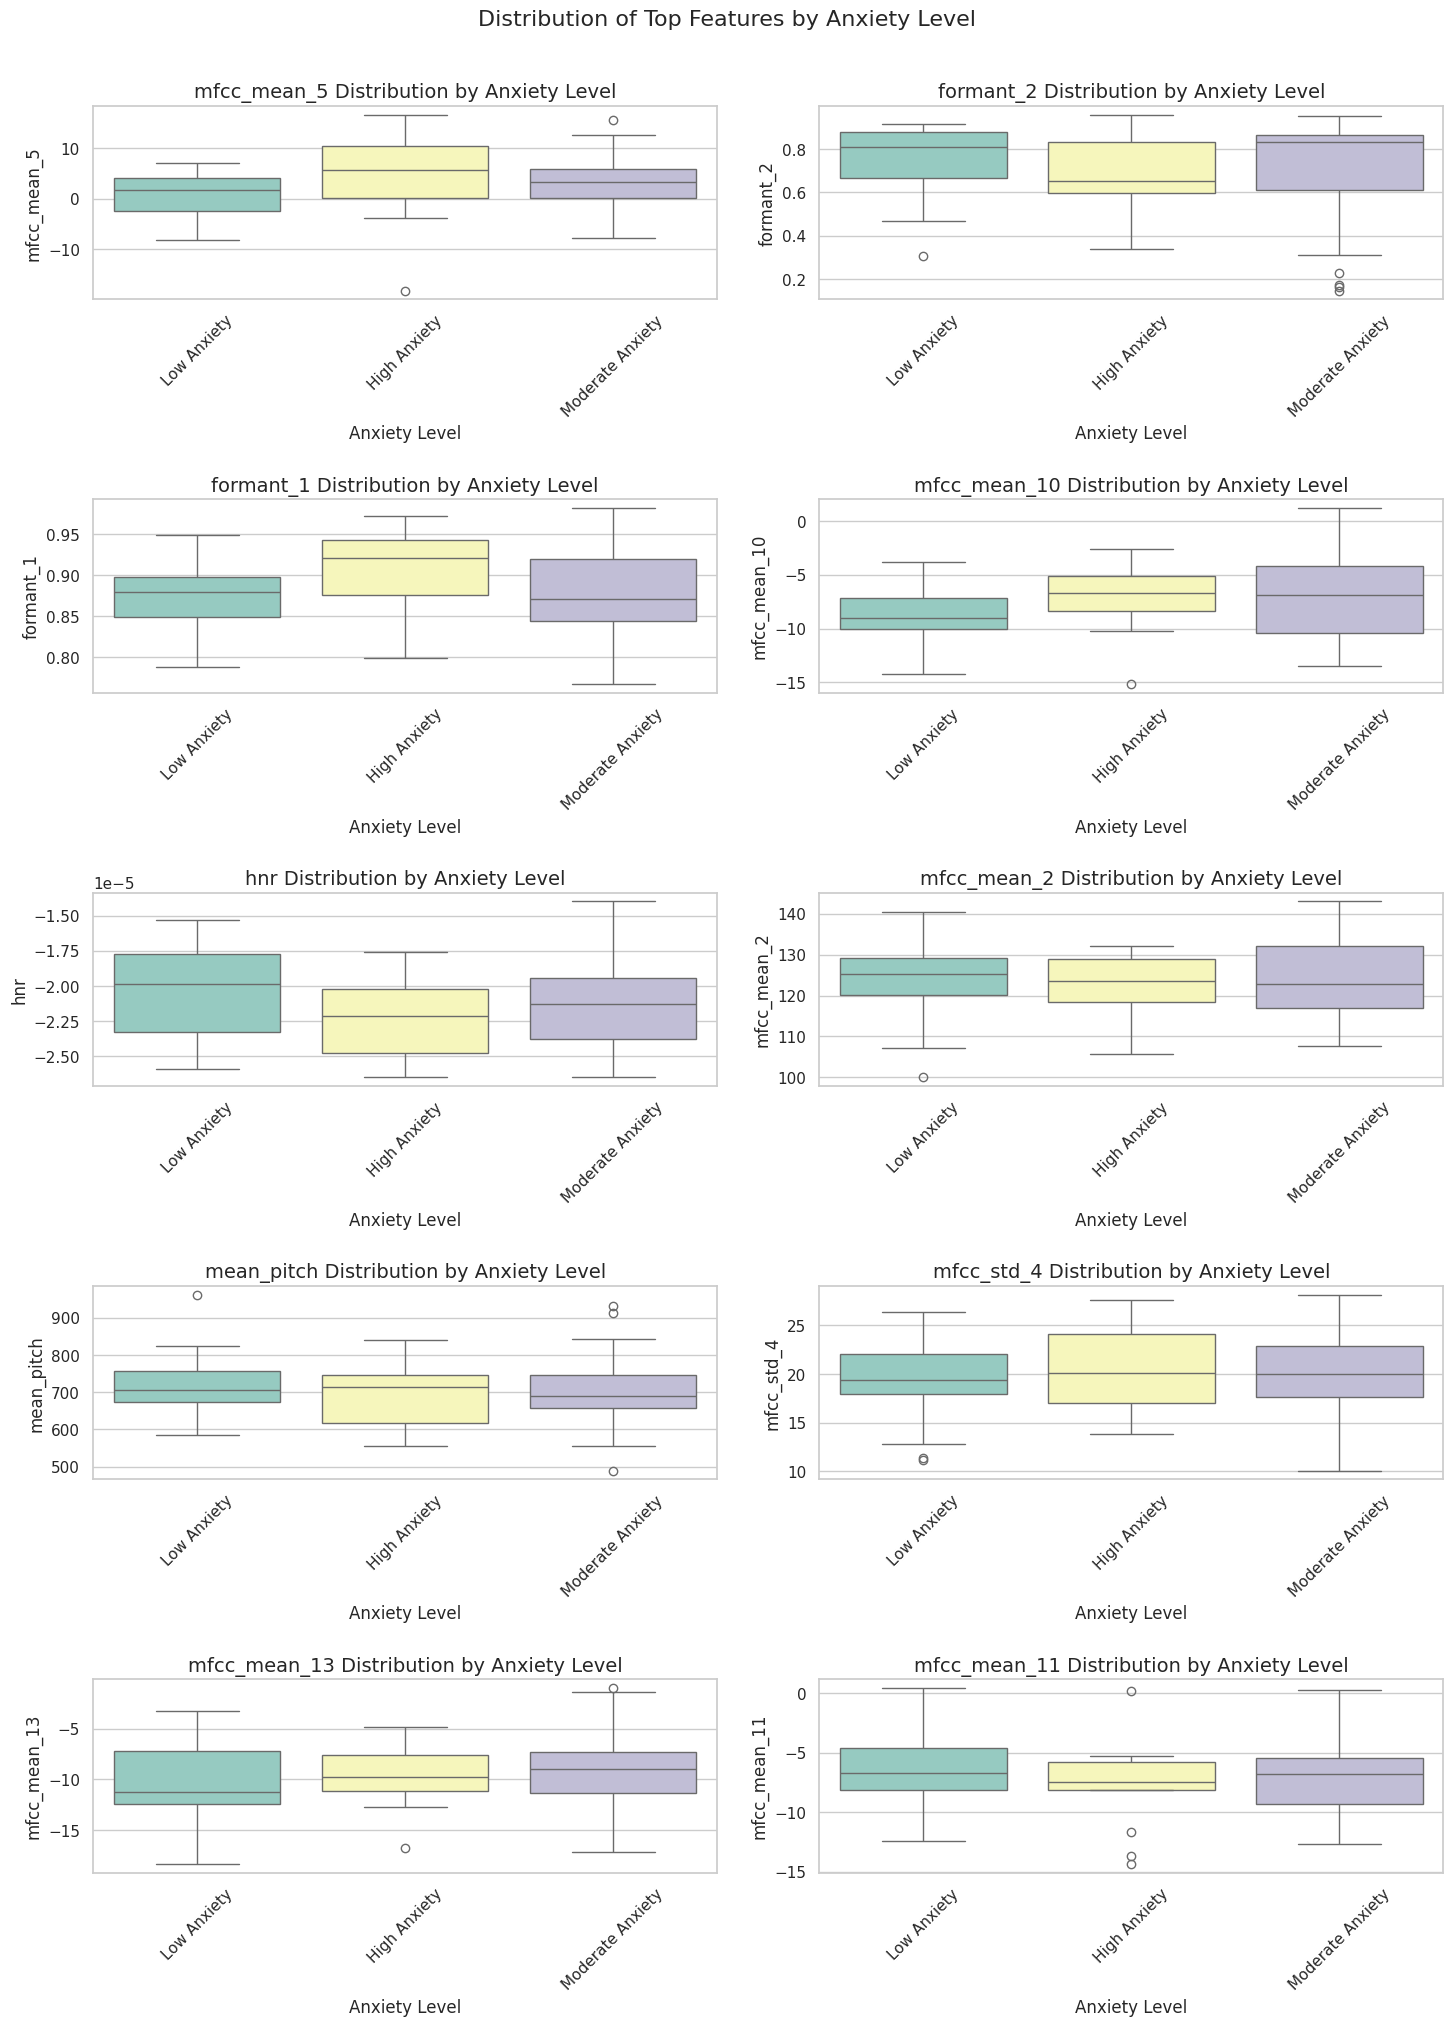

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
merged_data_path = "./Dataset/merged_spin_audio_data.csv"
merged_data = pd.read_csv(merged_data_path)

# Define top features
top_features = [
    'mfcc_mean_5', 'formant_2', 'formant_1', 'mfcc_mean_10', 'hnr', 
    'mfcc_mean_2', 'mean_pitch', 'mfcc_std_4', 'mfcc_mean_13', 'mfcc_mean_11'
]

# Set the theme for Seaborn
sns.set_theme(style="whitegrid")

# Create the figure
plt.figure(figsize=(15, 20))

# Plot each feature
for i, feature in enumerate(top_features, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(data=merged_data, x='Anxiety_Level', y=feature, hue='Anxiety_Level', palette="Set3", legend=False)
    plt.title(f'{feature} Distribution by Anxiety Level', fontsize=14)
    plt.xlabel('Anxiety Level', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout(pad=2.0)

# Add overall title
plt.suptitle('Distribution of Top Features by Anxiety Level', fontsize=16, y=1.02)

# Show the plot
plt.show()


In [11]:
import re
from collections import defaultdict

def extract_text_features(text):
    words = re.findall(r'\b\w+\b', text)
    word_count = len(words)
 
    sentences = re.split(r'[.!?]+', text)
    sentence_count = len([s for s in sentences if len(s.strip()) > 0])
    
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
    
    filler_words = ['um', 'uh', 'like', 'you know','so']
    filler_word_count = sum(text.lower().count(filler) for filler in filler_words)
    
    return {
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_sentence_length': avg_sentence_length,
        'filler_word_count': filler_word_count,
    }

transcripts_folder_path = "./Transcripts"

transcript_features = defaultdict(dict)

for transcript_file in os.listdir(transcripts_folder_path):
    if transcript_file.endswith('.txt'):
        with open(os.path.join(transcripts_folder_path, transcript_file), 'r') as file:
            text = file.read()
            features = extract_text_features(text)
            transcript_features[int(re.search(r'\d+', transcript_file).group())] = features

transcript_df = pd.DataFrame(transcript_features).T  
transcript_df.index.name = "Participant_Id"
transcript_df.to_csv('transcript_features.csv', index=True)

In [12]:
transcript_df.head()

,word_count,sentence_count,avg_sentence_length,filler_word_count
Participant_Id,,,,
28,420.0,95.0,4.421053,9.0
39,530.0,61.0,8.688525,28.0
69,307.0,64.0,4.796875,8.0
86,400.0,42.0,9.523810,19.0
101,177.0,29.0,6.103448,7.0


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

audio_data = pd.read_csv(r"merged_spin_audio_data.csv")
transcript_data = pd.read_csv(r"transcript_features.csv")
merged_data = pd.merge(audio_data, transcript_data, on="Participant_Id")

numeric_columns = merged_data.select_dtypes(include=[float, int]).columns
data_imputed_numeric = merged_data[numeric_columns].drop(columns=['shimmer'], errors='ignore')
imputer = SimpleImputer(strategy='median')
data_imputed_numeric = pd.DataFrame(imputer.fit_transform(data_imputed_numeric), columns=data_imputed_numeric.columns)

label_encoder = LabelEncoder()
merged_data['Anxiety_Level_encoded'] = label_encoder.fit_transform(merged_data['Anxiety_Level'])

X = data_imputed_numeric
y = merged_data['Anxiety_Level_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Model Accuracy:", accuracy)
print(report)


Model Accuracy: 0.9047619047619048
                  precision    recall  f1-score   support

    High Anxiety       0.00      0.00      0.00         2
     Low Anxiety       1.00      1.00      1.00         5
Moderate Anxiety       0.88      1.00      0.93        14

        accuracy                           0.90        21
       macro avg       0.62      0.67      0.64        21
    weighted avg       0.82      0.90      0.86        21



/projects/minorProject/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projects/minorProject/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projects/minorProject/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# TRY1 : GRIDSEARCHCV

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import pandas as pd

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Best Model Accuracy:", accuracy)
print(report)


Best Model Accuracy: 0.9047619047619048
                  precision    recall  f1-score   support

    High Anxiety       0.00      0.00      0.00         2
     Low Anxiety       1.00      1.00      1.00         5
Moderate Anxiety       0.88      1.00      0.93        14

        accuracy                           0.90        21
       macro avg       0.62      0.67      0.64        21
    weighted avg       0.82      0.90      0.86        21



/projects/minorProject/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projects/minorProject/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projects/minorProject/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# TRY2

In [15]:
%pip install xgboost lightgbm joblib

Note: you may need to restart the kernel to use updated packages.


In [21]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd


audio_data = pd.read_csv(r"merged_spin_audio_data.csv")
transcript_data = pd.read_csv(r"transcript_features.csv")
merged_data = pd.merge(audio_data, transcript_data, on="Participant_Id")

numeric_columns = merged_data.select_dtypes(include=[float, int]).columns
data_imputed_numeric = merged_data[numeric_columns].drop(columns=['shimmer'], errors='ignore')
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
data_imputed_numeric = pd.DataFrame(imputer.fit_transform(data_imputed_numeric), columns=data_imputed_numeric.columns)
data_imputed_numeric = pd.DataFrame(scaler.fit_transform(data_imputed_numeric), columns=data_imputed_numeric.columns)


label_encoder = LabelEncoder()
merged_data['Anxiety_Level_encoded'] = label_encoder.fit_transform(merged_data['Anxiety_Level'])

X = data_imputed_numeric
y = merged_data['Anxiety_Level_encoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)


stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Stacking Model Accuracy:", accuracy)
print(report)


joblib.dump(label_encoder, 'label_encoder.joblib')
joblib.dump(stacking_model, 'stacking_model.joblib')

/projects/minorProject/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:27:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/projects/minorProject/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:27:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/projects/minorProject/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:27:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/projects/minorProject/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:27:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/projects/minorProject/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:27:07] WARNING

Stacking Model Accuracy: 1.0
                  precision    recall  f1-score   support

    High Anxiety       1.00      1.00      1.00         2
     Low Anxiety       1.00      1.00      1.00         5
Moderate Anxiety       1.00      1.00      1.00        14

        accuracy                           1.00        21
       macro avg       1.00      1.00      1.00        21
    weighted avg       1.00      1.00      1.00        21



['stacking_model.joblib']

In [ ]:
%pip install imblearn

In [61]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib


audio_data = pd.read_csv(r"merged_spin_audio_data.csv")
transcript_data = pd.read_csv(r"transcript_features.csv")
merged_data = pd.merge(audio_data, transcript_data, on="Participant_Id")

print("Class distribution before processing:")
print(merged_data['Anxiety_Level'].value_counts(normalize=True))

numeric_columns = merged_data.select_dtypes(include=[float, int]).columns
data_imputed_numeric = merged_data[numeric_columns].drop(columns=['shimmer'], errors='ignore')

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_processed = preprocessor.fit_transform(data_imputed_numeric)
X = pd.DataFrame(X_processed, columns=data_imputed_numeric.columns)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(merged_data['Anxiety_Level'])


print("\nClass counts:")
for i, label in enumerate(label_encoder.classes_):
    count = (y == i).sum()
    print(f"{label}: {count} samples")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=class_weight_dict,
        random_state=42
    )),
    ('gb', GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )),
    ('xgb', XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=1,
        random_state=42
    ))
]

meta_classifier = LogisticRegression(
    multi_class='multinomial',
    class_weight=class_weight_dict,
    max_iter=1000,
    random_state=42
)

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_classifier,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    passthrough=True
)
print("\nTraining the model...")
stacking_model.fit(X_train_balanced, y_train_balanced)
y_pred_train = stacking_model.predict(X_train)
y_pred_test = stacking_model.predict(X_test)
print("\nTraining Results:")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train, target_names=label_encoder.classes_))
print("\nTest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))
joblib.dump(stacking_model, 'stacking_model.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')
joblib.dump(preprocessor, 'preprocessor.joblib')

def predict_anxiety_level(new_data):
    processed_data = preprocessor.transform(new_data)
    prediction = stacking_model.predict(processed_data)
    anxiety_level = label_encoder.inverse_transform(prediction)
    probabilities = stacking_model.predict_proba(processed_data)
    
    return anxiety_level[0], probabilities[0]
print("\nExample prediction:")
sample_data = X_test.iloc[[0]] 
prediction, probabilities = predict_anxiety_level(sample_data)
print(f"Predicted anxiety level: {prediction}")
print("Probability distribution:")
for level, prob in zip(label_encoder.classes_, probabilities):
    print(f"{level}: {prob:.2f}")

Class distribution before processing:
Anxiety_Level
Moderate Anxiety    0.580952
Low Anxiety         0.295238
High Anxiety        0.123810
Name: proportion, dtype: float64

Class counts:
High Anxiety: 13 samples
Low Anxiety: 31 samples
Moderate Anxiety: 61 samples

Training the model...


/projects/minorProject/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:02:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/projects/minorProject/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:02:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/projects/minorProject/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:02:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/projects/minorProject/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:02:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/projects/minorProject/l


Training Results:
Accuracy: 1.0

Classification Report:
                  precision    recall  f1-score   support

    High Anxiety       1.00      1.00      1.00        10
     Low Anxiety       1.00      1.00      1.00        25
Moderate Anxiety       1.00      1.00      1.00        49

        accuracy                           1.00        84
       macro avg       1.00      1.00      1.00        84
    weighted avg       1.00      1.00      1.00        84


Test Results:
Accuracy: 1.0

Classification Report:
                  precision    recall  f1-score   support

    High Anxiety       1.00      1.00      1.00         3
     Low Anxiety       1.00      1.00      1.00         6
Moderate Anxiety       1.00      1.00      1.00        12

        accuracy                           1.00        21
       macro avg       1.00      1.00      1.00        21
    weighted avg       1.00      1.00      1.00        21


Example prediction:
Predicted anxiety level: High Anxiety
Probability d

/projects/minorProject/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/projects/minorProject/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/projects/minorProject/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/projects/minorProject/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [60]:
import librosa
import pandas as pd
import joblib
import numpy as np
from sklearn.impute import SimpleImputer

stacking_model = joblib.load('stacking_model.joblib')
label_encoder = joblib.load('label_encoder.joblib')

def extract_audio_features(audio, sample_rate=22050):
    features = {}
    try:
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        for i in range(1, 14):
            features[f'mfcc_mean_{i}'] = float(np.mean(mfccs[i-1]))
            features[f'mfcc_std_{i}'] = float(np.std(mfccs[i-1]))
        pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sample_rate)
        pitch_mean = np.mean(pitches[pitches > 0])
        features['mean_pitch'] = float(pitch_mean) if not np.isnan(pitch_mean) else 0.0
        
        for key in features:
            if np.isinf(features[key]):
                features[key] = 0.0
            
    except Exception as e:
        print(f"Error in feature extraction: {str(e)}")
        raise

    return features

def predict_anxiety_level(audio_file):
   
    audio, sample_rate = librosa.load(audio_file, sr=None)
    
    features = extract_audio_features(audio, sample_rate)
    feature_vector = pd.DataFrame([features])
  
    expected_features = stacking_model.feature_names_in_

    aligned_features = pd.DataFrame(columns=expected_features)
    
    for feature in expected_features:
        if feature in feature_vector.columns:
            aligned_features[feature] = feature_vector[feature]
        else:
            aligned_features[feature] = 0.0

    aligned_features.columns = aligned_features.columns.astype(str)
    imputer = SimpleImputer(strategy='constant', fill_value=0.0)
    aligned_features_imputed = pd.DataFrame(
        imputer.fit_transform(aligned_features),
        columns=aligned_features.columns
    )
    if aligned_features_imputed.isna().any().any():
        raise ValueError("NaN values still present after imputation")
    anxiety_level_encoded = stacking_model.predict(aligned_features_imputed)
    anxiety_level = label_encoder.inverse_transform(anxiety_level_encoded)
    print(f"Predicted Anxiety Level: {anxiety_level[0]}")
    print("\nFeature values:")
    print(aligned_features_imputed.iloc[0])
    
    return anxiety_level[0]

audio_file = 'Voice1.wav'
predict_anxiety_level(audio_file)

Predicted Anxiety Level: Low Anxiety

Feature values:
Participant_Id                 0.000000
SPIN                           0.000000
mean_pitch                  1526.099976
pitch_variability              0.000000
mean_intensity                 0.000000
intensity_variability          0.000000
total_silence_duration         0.000000
num_pauses                     0.000000
spectral_entropy               0.000000
jitter                         0.000000
hnr                            0.000000
speech_segment_durations       0.000000
formant_1                      0.000000
formant_2                      0.000000
mfcc_mean_1                 -323.570679
mfcc_mean_2                   92.477852
mfcc_mean_3                   15.806959
mfcc_mean_4                   17.462296
mfcc_mean_5                   11.269514
mfcc_mean_6                   15.269487
mfcc_mean_7                    2.780673
mfcc_mean_8                    8.311428
mfcc_mean_9                  -13.991316
mfcc_mean_10              

'Low Anxiety'

In [ ]:
%pip install textblob

In [39]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/bishalde/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/bishalde/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [57]:
import pandas as pd
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
import re
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter

# Download required NLTK data with correct resource names
try:
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')  # Fixed resource name
    nltk.download('stopwords')
except Exception as e:
    print(f"Error downloading NLTK data: {str(e)}")

def extract_text_features(text):
    features = {}
    try:

        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        words = word_tokenize(text)
        sentences = sent_tokenize(text)

        features['word_count'] = len(words)
        features['avg_sentence_length'] = len(words) / len(sentences) if sentences else 0
        features['unique_words'] = len(set(words))
      
        blob = TextBlob(text)
        features['sentiment_polarity'] = blob.sentiment.polarity
        features['sentiment_subjectivity'] = blob.sentiment.subjectivity
        anxiety_keywords = [
            'worry', 'anxious', 'nervous', 'stress', 'fear', 'panic', 'tension',
            'afraid', 'scared', 'uncertain', 'doubt', 'concerned', 'uneasy'
        ]
        
        word_freq = Counter(words)
        features['anxiety_word_count'] = sum(word_freq[word] for word in anxiety_keywords if word in word_freq)
        features['anxiety_word_ratio'] = features['anxiety_word_count'] / features['word_count'] if features['word_count'] > 0 else 0
        
        try:
            pos_tags = nltk.pos_tag(words)
            pos_counts = Counter(tag for word, tag in pos_tags)

            total_tags = len(pos_tags)
            features['pronoun_ratio'] = sum(pos_counts[tag] for tag in ['PRP', 'PRP$']) / total_tags if total_tags > 0 else 0
            features['verb_ratio'] = sum(1 for _, tag in pos_tags if tag.startswith('VB')) / total_tags if total_tags > 0 else 0
            features['adj_ratio'] = sum(1 for _, tag in pos_tags if tag.startswith('JJ')) / total_tags if total_tags > 0 else 0
        except Exception as pos_error:
            print(f"Error in POS tagging: {str(pos_error)}")
            features['pronoun_ratio'] = 0
            features['verb_ratio'] = 0
            features['adj_ratio'] = 0
        
        for key in features:
            if isinstance(features[key], np.number):
                features[key] = float(features[key])
        
    except Exception as e:
        print(f"Error in feature extraction: {str(e)}")
        raise
        
    return features

def predict_anxiety_level(text):
    try:
        features = extract_text_features(text)
        feature_vector = pd.DataFrame([features])

        print("\nExtracted features:")
        print(feature_vector)
        expected_features = stacking_model.feature_names_in_
        
        print("\nExpected features:")
        print(expected_features)
        aligned_features = pd.DataFrame(columns=expected_features)

        for feature in expected_features:
            if feature in feature_vector.columns:
                aligned_features[feature] = feature_vector[feature]
            else:
                aligned_features[feature] = 0.0
        aligned_features.columns = aligned_features.columns.astype(str)
        imputer = SimpleImputer(strategy='constant', fill_value=0.0)
        aligned_features_imputed = pd.DataFrame(
            imputer.fit_transform(aligned_features),
            columns=aligned_features.columns
        )
        if aligned_features_imputed.isna().any().any():
            raise ValueError("NaN values still present after imputation")
        anxiety_level_encoded = stacking_model.predict(aligned_features_imputed)
        anxiety_level = label_encoder.inverse_transform(anxiety_level_encoded)
        print("\nAnalysis Results:")
        print("----------------")
        print(f"Predicted Anxiety Level: {anxiety_level[0]}")
        print("\nKey Metrics:")
        print(f"Word Count: {features['word_count']}")
        print(f"Anxiety-related Words: {features['anxiety_word_count']}")
        print(f"Sentiment Polarity: {features['sentiment_polarity']:.2f} (-1 negative to 1 positive)")
        print(f"Text Subjectivity: {features['sentiment_subjectivity']:.2f} (0 objective to 1 subjective)")
        
        return anxiety_level[0]
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        print("\nStacktrace:")
        import traceback
        traceback.print_exc()
        return None
if __name__ == "__main__":
    sample_text = """
    As I sit here in the soft glow of the morning sun, a gentle breeze brushes against my skin, bringing with it the scent of blooming flowers. I take a deep breath, inhaling the fresh air, and feel a sense of peace wash over me. The world outside is quiet, with only the distant chirping of birds filling the air. My thoughts are clear and relaxed, flowing like a serene river. I focus on the simple pleasure of the moment, feeling grateful for the little things—a warm cup of tea in my hands, the comfort of my favorite chair, and the soft rustle of leaves in the trees. There’s no rush, no pressure; I’m just here, enjoying the stillness. My mind drifts to pleasant memories, each one a reminder that life has its beautiful moments. I feel secure in the knowledge that everything will unfold as it should, and I’m ready to embrace whatever comes next with an open heart and a calm spirit.
    """
    
    try:
        print("Starting anxiety level prediction...")
        print("\nInput text:")
        print(sample_text)
        
        result = predict_anxiety_level(sample_text)
        
        if result is not None:
            print("\nDetailed Feature Analysis:")
            features = extract_text_features(sample_text)
            for key, value in features.items():
                print(f"{key}: {value}")
        else:
            print("\nPrediction failed. Please check the error messages above.")
            
    except Exception as e:
        print(f"An error occurred in main: {str(e)}")
        print("\nStacktrace:")
        import traceback
        traceback.print_exc()

Starting anxiety level prediction...

Input text:

    As I sit here in the soft glow of the morning sun, a gentle breeze brushes against my skin, bringing with it the scent of blooming flowers. I take a deep breath, inhaling the fresh air, and feel a sense of peace wash over me. The world outside is quiet, with only the distant chirping of birds filling the air. My thoughts are clear and relaxed, flowing like a serene river. I focus on the simple pleasure of the moment, feeling grateful for the little things—a warm cup of tea in my hands, the comfort of my favorite chair, and the soft rustle of leaves in the trees. There’s no rush, no pressure; I’m just here, enjoying the stillness. My mind drifts to pleasant memories, each one a reminder that life has its beautiful moments. I feel secure in the knowledge that everything will unfold as it should, and I’m ready to embrace whatever comes next with an open heart and a calm spirit.
    

Extracted features:
   word_count  avg_sentence_len

[nltk_data] Downloading package punkt to /home/bishalde/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bishalde/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bishalde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
import pandas as pd
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
import re
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter

try:
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('stopwords')
except Exception as e:
    print(f"Error downloading NLTK data: {str(e)}")

stacking_model = joblib.load('stacking_model.joblib')
label_encoder = joblib.load('label_encoder.joblib')
preprocessor = joblib.load('preprocessor.joblib')
def extract_text_features(text):
    features = {}
    try:
      
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        
        words = word_tokenize(text)
        sentences = sent_tokenize(text)
        
        features['word_count'] = float(len(words))
        features['sentence_count'] = float(len(sentences))
        features['avg_words_per_sentence'] = features['word_count'] / len(sentences) if sentences else 0.0
        features['unique_words'] = float(len(set(words)))
        features['lexical_density'] = features['unique_words'] / features['word_count'] if features['word_count'] > 0 else 0.0
        
        blob = TextBlob(text)
        features['sentiment_polarity'] = float(blob.sentiment.polarity)
        features['sentiment_subjectivity'] = float(blob.sentiment.subjectivity)
        
        anxiety_keywords = {
            'worry', 'anxious', 'nervous', 'stress', 'fear', 'panic', 'tension',
            'afraid', 'scared', 'uncertain', 'doubt', 'concerned', 'uneasy',
            'anxiety', 'worried', 'stressful', 'fearful', 'panicked', 'tense',
            'frightened', 'terrified', 'apprehensive', 'stressed'
        }
        
        word_freq = Counter(words)
        anxiety_word_count = sum(word_freq[word] for word in anxiety_keywords if word in word_freq)
        features['anxiety_word_count'] = float(anxiety_word_count)
        features['anxiety_word_ratio'] = anxiety_word_count / features['word_count'] if features['word_count'] > 0 else 0.0
        
        try:
            pos_tags = nltk.pos_tag(words)
            pos_counts = Counter(tag for _, tag in pos_tags)
            
            total_tags = len(pos_tags)
            features['pronoun_ratio'] = float(sum(pos_counts[tag] for tag in ['PRP', 'PRP$']) / total_tags if total_tags > 0 else 0)
            features['verb_ratio'] = float(sum(1 for _, tag in pos_tags if tag.startswith('VB')) / total_tags if total_tags > 0 else 0)
            features['adj_ratio'] = float(sum(1 for _, tag in pos_tags if tag.startswith('JJ')) / total_tags if total_tags > 0 else 0)
            features['adv_ratio'] = float(sum(1 for _, tag in pos_tags if tag.startswith('RB')) / total_tags if total_tags > 0 else 0)
        except Exception as pos_error:
            print(f"Warning - Error in POS tagging: {str(pos_error)}")
            features.update({
                'pronoun_ratio': 0.0,
                'verb_ratio': 0.0,
                'adj_ratio': 0.0,
                'adv_ratio': 0.0
            })
        
 
        word_lengths = [len(word) for word in words]
        features['avg_word_length'] = float(np.mean(word_lengths) if word_lengths else 0)
        features['std_word_length'] = float(np.std(word_lengths) if word_lengths else 0)
        

        first_person_pronouns = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves'}
        first_person_count = sum(word_freq[word] for word in first_person_pronouns if word in word_freq)
        features['first_person_ratio'] = float(first_person_count / features['word_count'] if features['word_count'] > 0 else 0)
        
    except Exception as e:
        print(f"Error in feature extraction: {str(e)}")
        raise
        
    return features

def predict_anxiety_level(text):
    try:
    
        features = extract_text_features(text)
        
 
        feature_vector = pd.DataFrame([features])
        
     
        expected_features = stacking_model.feature_names_in_
        
        aligned_features = pd.DataFrame(columns=expected_features)
        

        for feature in expected_features:
            if feature in feature_vector.columns:
                aligned_features[feature] = feature_vector[feature]
            else:
                aligned_features[feature] = 0.0
        
 
        processed_features = preprocessor.transform(aligned_features)
        
 
        prediction = stacking_model.predict(processed_features)
        probabilities = stacking_model.predict_proba(processed_features)
        

        anxiety_level = label_encoder.inverse_transform(prediction)[0]
        
    
        print("\nAnxiety Analysis Results:")
        print("========================")
        print(f"\nPredicted Anxiety Level: {anxiety_level}")
        print("\nConfidence Scores:")
        for level, prob in zip(label_encoder.classes_, probabilities[0]):
            print(f"{level}: {prob:.2f}")
        
        print("\nKey Text Metrics:")
        print(f"Word Count: {features['word_count']:.0f}")
        print(f"Anxiety-related Words: {features['anxiety_word_count']:.0f}")
        print(f"Sentiment Polarity: {features['sentiment_polarity']:.2f} (-1 negative to 1 positive)")
        print(f"Text Subjectivity: {features['sentiment_subjectivity']:.2f} (0 objective to 1 subjective)")
        print(f"First Person Pronoun Usage: {features['first_person_ratio']:.2%}")
        
        return {
            'prediction': anxiety_level,
            'probabilities': dict(zip(label_encoder.classes_, probabilities[0])),
            'metrics': {
                'word_count': features['word_count'],
                'anxiety_words': features['anxiety_word_count'],
                'sentiment': features['sentiment_polarity'],
                'subjectivity': features['sentiment_subjectivity']
            }
        }
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    example_texts = [
        """As I sit here in the soft glow of the morning sun, a gentle breeze brushes against my skin, bringing with it the scent of blooming flowers. I take a deep breath, inhaling the fresh air, and feel a sense of peace wash over me. The world outside is quiet, with only the distant chirping of birds filling the air. My thoughts are clear and relaxed, flowing like a serene river. I focus on the simple pleasure of the moment, feeling grateful for the little things—a warm cup of tea in my hands, the comfort of my favorite chair, and the soft rustle of leaves in the trees. There’s no rush, no pressure; I’m just here, enjoying the stillness. My mind drifts to pleasant memories, each one a reminder that life has its beautiful moments. I feel secure in the knowledge that everything will unfold as it should, and I’m ready to embrace whatever comes next with an open heart and a calm spirit."""
    ]
    
    print("Testing multiple example texts for validation...")
    
    for i, text in enumerate(example_texts, 1):
        print(f"\n\nExample {i}:")
        print("Input text:", text[:100] + "...")
        
        result = predict_anxiety_level(text)
        
        if result:
            print("\nDetailed Feature Analysis:")
            features = extract_text_features(text)
            for key, value in features.items():
                print(f"{key}: {value:.4f}")

Testing multiple example texts for validation...


Example 1:
Input text: As I sit here in the soft glow of the morning sun, a gentle breeze brushes against my skin, bringing...

Anxiety Analysis Results:

Predicted Anxiety Level: Moderate Anxiety

Confidence Scores:
High Anxiety: 0.04
Low Anxiety: 0.05
Moderate Anxiety: 0.91

Key Text Metrics:
Word Count: 164
Anxiety-related Words: 0
Sentiment Polarity: 0.21 (-1 negative to 1 positive)
Text Subjectivity: 0.54 (0 objective to 1 subjective)
First Person Pronoun Usage: 6.10%

Detailed Feature Analysis:
word_count: 164.0000
sentence_count: 1.0000
avg_words_per_sentence: 164.0000
unique_words: 112.0000
lexical_density: 0.6829
sentiment_polarity: 0.2089
sentiment_subjectivity: 0.5405
anxiety_word_count: 0.0000
anxiety_word_ratio: 0.0000
pronoun_ratio: 0.0549
verb_ratio: 0.1220
adj_ratio: 0.1220
adv_ratio: 0.0244
avg_word_length: 4.2561
std_word_length: 2.1686
first_person_ratio: 0.0610


[nltk_data] Downloading package punkt to /home/bishalde/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bishalde/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bishalde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/projects/minorProject/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/projects/minorProject/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/projects/minorProject/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestCl

In [18]:
%pip install sounddevice

Note: you may need to restart the kernel to use updated packages.


In [19]:
import sounddevice as sd
print(sd.query_devices())

In [20]:
import sounddevice as sd
import numpy as np
import librosa
import pandas as pd
import joblib
import time

# Load the stacked model and label encoder
stacking_model = joblib.load('stacking_model.joblib')
label_encoder = joblib.load('label_encoder.joblib')

def countdown_timer(seconds, message=""):
    for sec in range(seconds, 0, -1):
        print(f"{message} {sec}", end="\r")
        time.sleep(1)
    print(" " * len(message + str(seconds)) + "\r", end="")  # Clear the line

def record_audio(duration=19, sample_rate=22050):
    countdown_timer(3, "Starting recording in")
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float64')
    countdown_timer(duration, "time:")
    
    sd.wait()  
    print("Complete")
    return np.squeeze(audio)

def extract_audio_features(audio, sample_rate=22050):
    features = {}
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    for i in range(1, 14):
        features[f'mfcc_mean_{i}'] = np.mean(mfccs[i-1])
        features[f'mfcc_std_{i}'] = np.std(mfccs[i-1])

    pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sample_rate)
    pitch_mean = np.mean(pitches[pitches > 0])
    features['mean_pitch'] = pitch_mean if not np.isnan(pitch_mean) else 0
    
    return features

def predict_anxiety_level():
    audio = record_audio()
    features = extract_audio_features(audio)
    feature_vector = pd.DataFrame([features])


    missing_features = set(stacking_model.feature_names_in_) - set(feature_vector.columns)
    for feat in missing_features:
        feature_vector[feat] = 0

    anxiety_level_encoded = stacking_model.predict(feature_vector)
    anxiety_level = label_encoder.inverse_transform(anxiety_level_encoded)
    print(f"Predicted Anxiety Level: {anxiety_level[0]}")

predict_anxiety_level()


Recording...          1


PortAudioError: Error querying device -1

In [6]:
import sounddevice as sd
import numpy as np
import librosa
import pandas as pd
import joblib
import time

rf_classifier = joblib.load('anxiety_model.joblib')
label_encoder = joblib.load('label_encoder.joblib')

def countdown_timer(seconds, message=""):
    for sec in range(seconds, 0, -1):
        print(f"{message} {sec}", end="\r")
        time.sleep(1)
    print(" " * len(message + str(seconds)) + "\r", end="")  # Clear the line

def record_audio(duration=19, sample_rate=22050):
    countdown_timer(3, "Starting recording in")
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float64')
    countdown_timer(duration, "time:")
    
    sd.wait()  
    print("Complete")
    return np.squeeze(audio)

def extract_audio_features(audio, sample_rate=22050):
    features = {}
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    for i in range(1, 14):
        features[f'mfcc_mean_{i}'] = np.mean(mfccs[i-1])
        features[f'mfcc_std_{i}'] = np.std(mfccs[i-1])

    pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sample_rate)
    pitch_mean = np.mean(pitches[pitches > 0])
    features['mean_pitch'] = pitch_mean if not np.isnan(pitch_mean) else 0
    
    return features

def predict_anxiety_level():
    audio = record_audio()
    features = extract_audio_features(audio)
    feature_vector = pd.DataFrame([features])

    missing_features = set(rf_classifier.feature_names_in_) - set(feature_vector.columns)
    for feat in missing_features:
        feature_vector[feat] = 0

    anxiety_level_encoded = rf_classifier.predict(feature_vector)
    anxiety_level = label_encoder.inverse_transform(anxiety_level_encoded)
    print(f"Predicted Anxiety Level: {anxiety_level[0]}")

predict_anxiety_level()


Recording...          1
Complete
Predicted Anxiety Level: Moderate Anxiety


C:\Users\ROG\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
